## Julia on Colaboratory ##

[Colaboratory](https://colab.research.google.com) does not provide native support for the [Julia programming language](https://julialang.org). However, since Colaboratory gives you root access to the machine that runs your notebook (the *“runtime”* in Colaboratory terminology), we can install Julia support by uploading a specially crafted Julia notebook  – *this* notebook. We then install Julia and [IJulia](https://github.com/JuliaLang/IJulia.jl) ([Jupyter](https://jupyter.org)/Colaboratory notebook support) and reload the notebook so that Colaboratory detects and initiates what we installed.

In brief:

1. **Run the cell below**
2. **Reload the page**
3. **Edit the notebook name and start hacking Julia code below**

**If your runtime resets**, either manually or if left idle for some time, **repeat steps 1 and 2**.

### Acknowledgements ###

This hack by Pontus Stenetorp is an adaptation of [James Bradbury’s original Colaboratory Julia hack](https://discourse.julialang.org/t/julia-on-google-colab-free-gpu-accelerated-shareable-notebooks/15319/27), that broke some time in September 2019 as Colaboratory increased their level of notebook runtime isolation. There also appears to be CUDA compilation support installed by default for each notebook runtime type in October 2019, which shaves off a good 15 minutes or so from the original hack’s installation time.

In [0]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add Plots; add PyPlot; add IJulia; add Knet;"'
julia -e 'using Pkg; pkg"build Knet;"'

--2020-05-23 14:24:08--  https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 gce internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz [following]
--2020-05-23 14:24:09--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 2a00:1450:400c:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95929584 (91M) [application/x-gzip]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[===================>]

In [0]:
using Pkg; for p in ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data,adam, sigm
using Base.Iterators: flatten
using Statistics: mean
using Plots;
import .Iterators: cycle

In [3]:
include(Knet.dir("data", "mnist.jl"))

xtrn, ytrn, xtst, ytst = mnist();
dtrn, dtst = mnistdata();

println.(summary.((xtrn, xtst, ytrn, ytst)));
println.(summary.((dtrn, dtst)));

┌ Info: Loading MNIST...
└ @ Main /root/.julia/packages/Knet/bTNMd/data/mnist.jl:33


28×28×1×60000 Array{Float32,4}
28×28×1×10000 Array{Float32,4}
60000-element Array{UInt8,1}
10000-element Array{UInt8,1}
600-element Data{Tuple{KnetArray{Float32,4},Array{UInt8,1}}}
100-element Data{Tuple{KnetArray{Float32,4},Array{UInt8,1}}}


In [4]:
println.(summary.((first(dtrn), first(dtst))));

(K32(28,28,1,100)[0.0⋯], UInt8[0x05, 0x0a, 0x04, 0x01, 0x09, 0x02, 0x01, 0x03, 0x01, 0x04, 0x03, 0x05, 0x03, 0x06, 0x01, 0x07, 0x02, 0x08, 0x06, 0x09, 0x04, 0x0a, 0x09, 0x01, 0x01, 0x02, 0x04, 0x03, 0x02, 0x07, 0x03, 0x08, 0x06, 0x09, 0x0a, 0x05, 0x06, 0x0a, 0x07, 0x06, 0x01, 0x08, 0x07, 0x09, 0x03, 0x09, 0x08, 0x05, 0x09, 0x03, 0x03, 0x0a, 0x07, 0x04, 0x09, 0x08, 0x0a, 0x09, 0x04, 0x01, 0x04, 0x04, 0x06, 0x0a, 0x04, 0x05, 0x06, 0x01, 0x0a, 0x0a, 0x01, 0x07, 0x01, 0x06, 0x03, 0x0a, 0x02, 0x01, 0x01, 0x07, 0x09, 0x0a, 0x02, 0x06, 0x07, 0x08, 0x03, 0x09, 0x0a, 0x04, 0x06, 0x07, 0x04, 0x06, 0x08, 0x0a, 0x07, 0x08, 0x03, 0x01])
(K32(28,28,1,100)[0.0⋯], UInt8[0x07, 0x02, 0x01, 0x0a, 0x04, 0x01, 0x04, 0x09, 0x05, 0x09, 0x0a, 0x06, 0x09, 0x0a, 0x01, 0x05, 0x09, 0x07, 0x03, 0x04, 0x09, 0x06, 0x06, 0x05, 0x04, 0x0a, 0x07, 0x04, 0x0a, 0x01, 0x03, 0x01, 0x03, 0x04, 0x07, 0x02, 0x07, 0x01, 0x02, 0x01, 0x01, 0x07, 0x04, 0x02, 0x03, 0x05, 0x01, 0x02, 0x04, 0x04, 0x06, 0x03, 0x05, 0x05, 0x06, 0x0a, 0

In [5]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = pool(c.f.(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int, w2::Int, cx::Int, cy::Int, f=sigm; pdrop=0) = Conv(param(w1, w2, cx, cy), param0(1, 1, cy, 1), f, pdrop)

Conv

In [6]:
# Define a Dense layer
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x, d.p)) .+ d.b)
Dense(i::Int, o::Int, f=identity; pdrop=0) = Dense(param(o, i), param0(o), f, pdrop)

Dense

In [0]:
# Define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x)       = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x, y)    = nll(c(x), y)
(c::Chain)(d::Data) = mean(c(x, y) for (x, y) in d)

In [8]:
chain_model = Chain(Conv(7, 7, 1, 5), Dense(605, 10))
summary.(l.w for l in chain_model.layers)

2-element Array{String,1}:
 "7×7×1×5 AutoGrad.Param{KnetArray{Float32,4}}"
 "10×605 AutoGrad.Param{KnetArray{Float32,2}}" 

In [9]:
function chain_train_result(file, model; o...)
    takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
    r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
           for x in takeevery(length(dtrn), progress(sgd(model, repeat(dtrn, 100), lr=0.15))))
    r = reshape(collect(Float32,flatten(r)),(4,:))
    Knet.save(file,"results",r)
    Knet.gc()
    println(minimum(r,dims=2))
    return r
end

chain_train_result (generic function with 1 method)

In [10]:
chain_train_model = chain_train_result("lenet.jld2", chain_model);

┌ Warning: repeat(d::Data,n) is deprecated, use IterTools.ncycle instead.
└ @ Knet /root/.julia/packages/Knet/bTNMd/src/data.jl:92
┣████████████████████┫ [100.00%, 60000/60000, 02:50/02:50, 352.19i/s] 


Float32[0.031484812; 0.04629118; 0.00915; 0.0147]


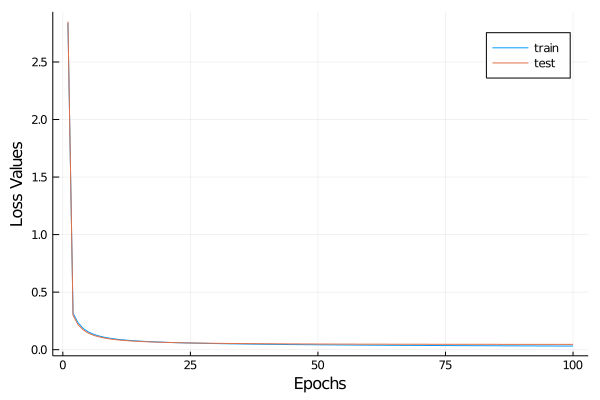

In [11]:
plot([chain_train_model[1,:], chain_train_model[2,:]], labels=[:train :test ], xlabel="Epochs", ylabel="Loss Values")

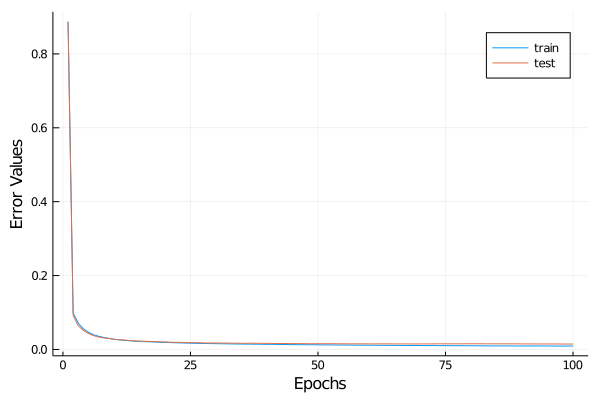

In [12]:
plot([chain_train_model[3,:], chain_train_model[4,:]], labels=[:train :test ], xlabel="Epochs",ylabel="Error Values")

In [13]:
chain_model_adam = Chain(Conv(7, 7, 1, 5), Dense(605, 10))
summary.(l.w for l in chain_model_adam.layers)

2-element Array{String,1}:
 "7×7×1×5 AutoGrad.Param{KnetArray{Float32,4}}"
 "10×605 AutoGrad.Param{KnetArray{Float32,2}}" 

In [14]:
function train_Adam_optimizer(file, model; o...)
    takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
    r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
           for x in takeevery(length(dtrn), progress(adam(model,repeat(dtrn,100)))))
    r = reshape(collect(Float32,flatten(r)),(4,:))
    Knet.save(file,"results",r)
    Knet.gc()
    println(minimum(r,dims=2))
    return r
end

train_Adam_optimizer (generic function with 1 method)

In [15]:
model_train_adam= train_Adam_optimizer("cnnAdam.jld2", chain_model_adam)

┣████████████████████┫ [100.00%, 60000/60000, 03:02/03:02, 329.32i/s] 


Float32[0.01809951; 0.047592808; 0.0057; 0.0143]


4×100 Array{Float32,2}:
 2.45394  0.396181  0.277393   0.219405   …  0.0184214   0.0182583  0.0180995
 2.44911  0.376588  0.261199   0.206712      0.0528567   0.0530564  0.0532616
 0.88975  0.1091    0.0807667  0.0636333     0.00581667  0.00575    0.0057   
 0.8912   0.1011    0.0739     0.0599        0.0166      0.0166     0.0167   

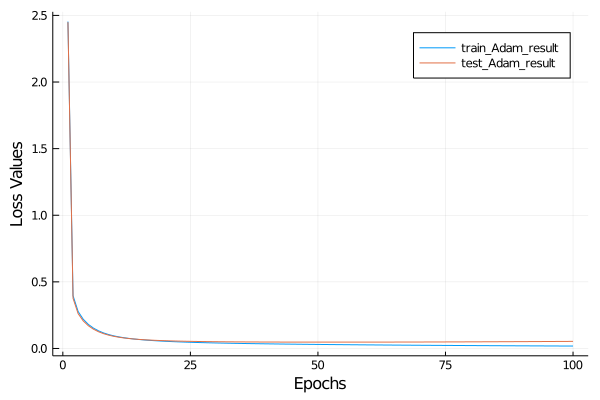

In [16]:
plot([model_train_adam[1,:], model_train_adam[2,:]], labels=[:train_Adam_result :test_Adam_result ], xlabel="Epochs", ylabel="Loss Values") 

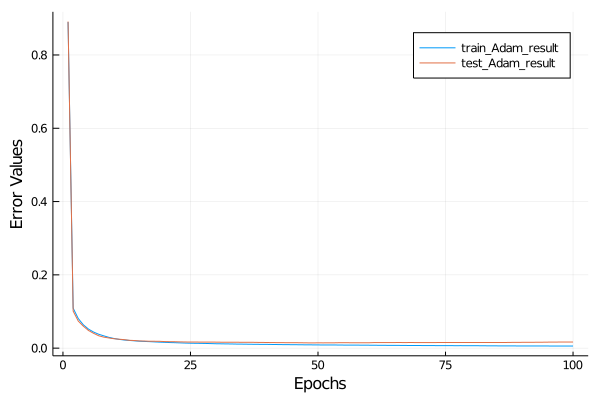

In [17]:
plot([model_train_adam[3,:], model_train_adam[4,:]], labels=[:train_Adam_result :test_Adam_result ], xlabel="Epochs", ylabel="Error Values") 

In [27]:
example_model1 = Chain(Conv(5,5,1,20),
                        Dense(2880,10))
summary.(l.w for l in example_model1.layers)

2-element Array{String,1}:
 "5×5×1×20 AutoGrad.Param{KnetArray{Float32,4}}"
 "10×2880 AutoGrad.Param{KnetArray{Float32,2}}" 

In [28]:
example_model1_train = chain_train_result("Advan.jld2", example_model1)

┣████████████████████┫ [100.00%, 60000/60000, 02:48/02:48, 356.18i/s] 


Float32[0.026645157; 0.049315874; 0.0074; 0.0152]


4×100 Array{Float32,2}:
 7.78015  0.433563  0.363263  0.335236  …  0.027065   0.026854    0.0266452
 7.7427   0.410372  0.343762  0.317806     0.0493501  0.0493324   0.0493159
 0.90085  0.138283  0.1117    0.1043       0.0075     0.00746667  0.0074   
 0.8991   0.1276    0.1008    0.0959       0.0156     0.0156      0.0156   

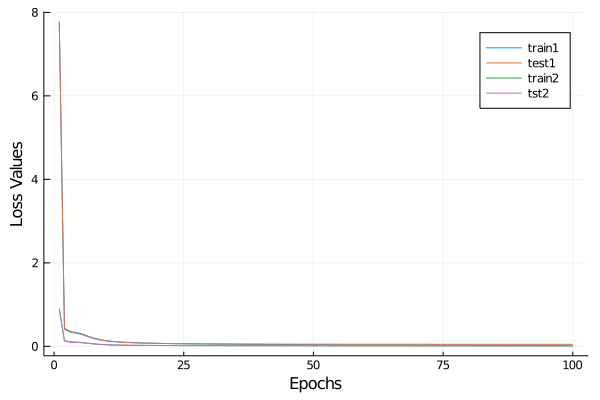

In [29]:
plot([example_model1_train[1,:], example_model1_train[2,:], 
      example_model1_train[3,:], example_model1_train[4,:]],
     labels=[:train1 :test1 :train2 :tst2 ], xlabel="Epochs", ylabel="Loss Values") 

In [32]:
example_model2 = Chain(Conv(7,7,1,10),
                        Dense(1210,10))
summary.(l.w for l in example_model2.layers)

2-element Array{String,1}:
 "7×7×1×10 AutoGrad.Param{KnetArray{Float32,4}}"
 "10×1210 AutoGrad.Param{KnetArray{Float32,2}}" 

In [33]:
example_model2_train = chain_train_result("Advan.jld2", example_model2)

┣████████████████████┫ [100.00%, 60000/60000, 02:36/02:36, 384.84i/s] 


Float32[0.022524536; 0.037011493; 0.0061333333; 0.0119]


4×100 Array{Float32,2}:
 4.42226   0.331899  0.256142   …  0.0228612   0.022692    0.0225245 
 4.413     0.314221  0.241299      0.0370853   0.0370478   0.0370115 
 0.887633  0.102983  0.0810333     0.00623333  0.00621667  0.00613333
 0.8865    0.095     0.0747        0.0119      0.0119      0.0119    

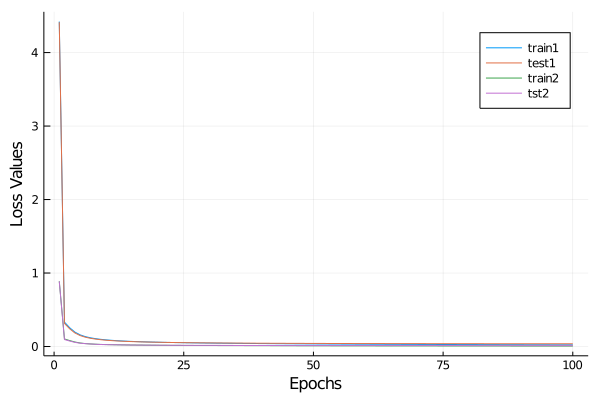

In [34]:
plot([example_model2_train[1,:], example_model2_train[2,:], 
      example_model2_train[3,:], example_model2_train[4,:]],
     labels=[:train1 :test1 :train2 :tst2 ], xlabel="Epochs", ylabel="Loss Values") 